# 7-7. 프로젝트: 인물 모드 문제점 찾기

프로젝트를 통해 인물모드의 문제점을 찾아보자!!

## Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [1]:
import os
import urllib #웹에서 데이터를 다운로드할 때 사용
import cv2 #OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1350, 1080, 3)


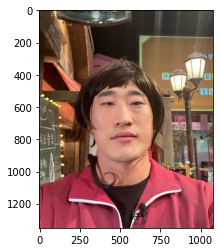

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/girl.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe93dfb4340>)

In [4]:
model = semantic_segmentation() #모델에 이미지 입력
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

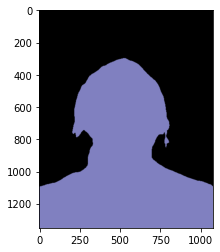

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]

array([192, 128, 128])

In [12]:
seg_color = (128,128,192)

(1350, 1080)


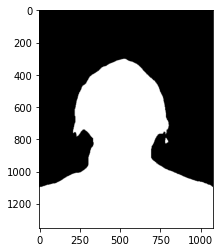

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

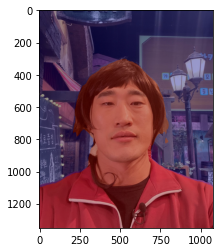

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

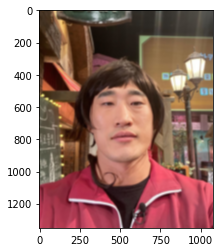

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

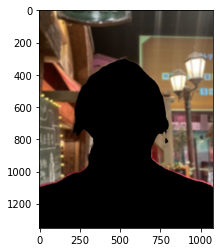

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

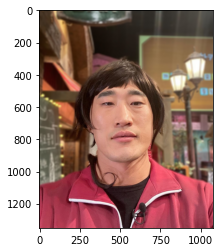

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

깔꼼하게
분리되어
결과가 잘 나왔다.!
성공..`~!!!

### 호랑이 이미지 검출

(427, 640, 3)


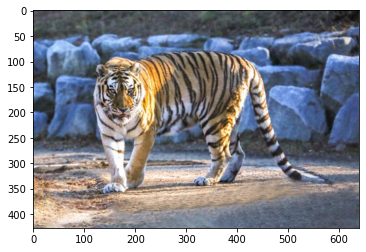

In [27]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/tiger.jpg'  
cat_img_orig = cv2.imread(cat_img_path) 

print(cat_img_orig.shape)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

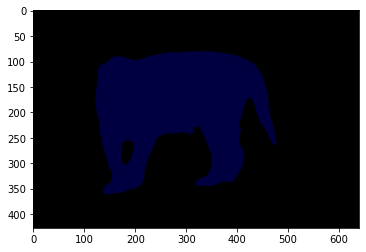

In [28]:
model = semantic_segmentation() #모델에 이미지 입력
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(cat_img_path)

plt.imshow(output)
plt.show()

In [29]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [30]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [31]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [32]:
colormap[8] #cat

array([64,  0,  0])

In [33]:
seg_color = (0,0,64)

(427, 640)


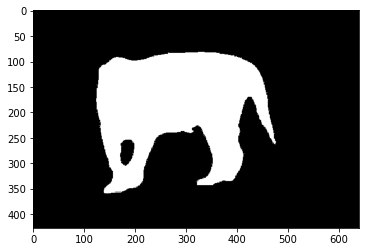

In [34]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

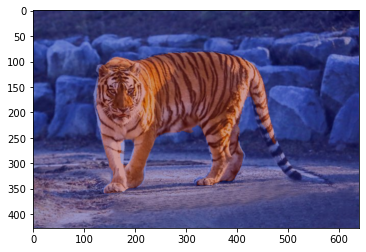

In [35]:
img_show = cat_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

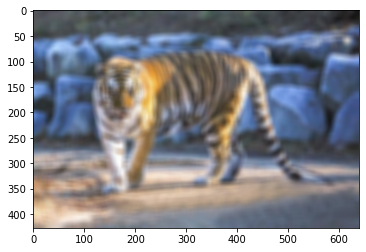

In [37]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

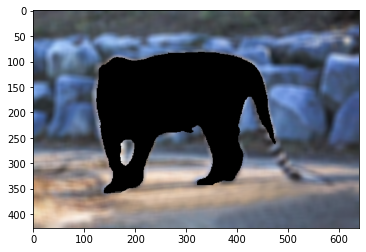

In [38]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

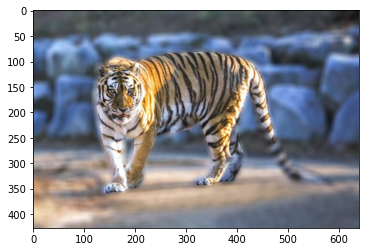

In [39]:
img_concat2 = np.where(img_mask_color==255, cat_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

꼬리부분이 아쉽긴하지만 호랑이의 늠름한 모습이 잘 담겨나왔다.

이제는 폭포사진에 호랑이를 끼얹어보자!

(512, 1024, 3)


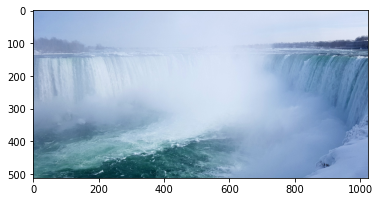

In [40]:
# 배경 이미지
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pp.jfif'
img_falls = cv2.imread(img_path4) 

print(img_falls.shape)
plt.imshow(cv2.cvtColor(img_falls, cv2.COLOR_BGR2RGB))
plt.show()


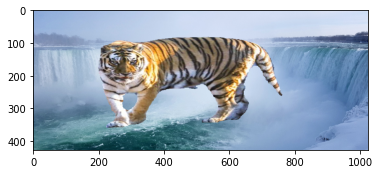

In [42]:
# 이미지, 배경사진, 이미지 mask 리사이즈
cat_resized = cv2.resize(cat_img_orig, (img_falls.shape[1], cat_img_orig.shape[0]))
img_falls_resized = cv2.resize(img_falls, (img_falls.shape[1], cat_img_orig.shape[0]))

cat_img_mask_resized = cv2.resize(img_mask_color, (img_falls.shape[1], cat_img_orig.shape[0]))

# 배경 영상과 고양이 영상을 합치기
cat_falls_concat = np.where(cat_img_mask_resized == 255, cat_resized, img_falls_resized)

plt.imshow(cv2.cvtColor(cat_falls_concat, cv2.COLOR_BGR2RGB))
plt.show()

호랑이 전용 풀장 너낌

## Step 2. 사진에서 문제점 찾기

문제점을 굳이 찾는다면 

호랑이 꼬리부분이 덜 인식되었다.

어흥

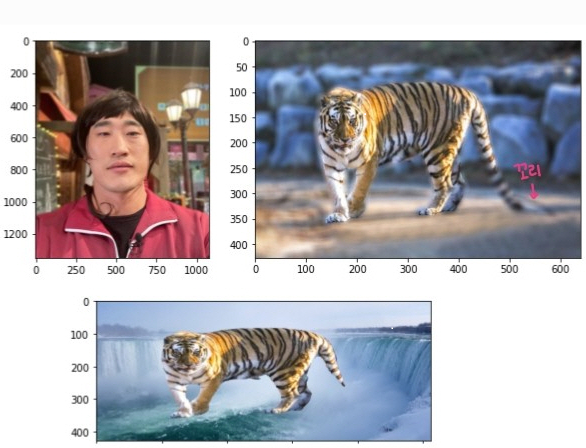

### Step 3. 해결 방법을 제안해 보기


음,,, 해결방법은

회고

Go go

# 회고

이번은 Segmentation 개념을 이해해보고, 여러 사진들을 이용해서 model을 적용해보았다.

해결방법을 어떻게 찾아볼까
해결방법을 찾으려면 내가 어떤 부분에서 문제를 삼을지?? 고민을 해보아야겠지만

사진 결과가 마음에 든다.
해결책을 안찾아봐도 되겠단 생각이 든다.

점수 안녕~~~~
빠이빠이🖐